# Environment setup

## Download code and data


In [10]:
!pip install imagecodecs tifffile stardist gdown

In [2]:
# Clone the GitHub repository and cd into it
%rm -rf ml-segmentation-project/
!git clone 'https://github.com/CRefice/ml-segmentation-project.git'
%cd ml-segmentation-project/

Cloning into 'ml-segmentation-project'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 294 (delta 20), reused 22 (delta 10), pack-reused 255
Receiving objects: 100% (294/294), 10.87 MiB | 29.15 MiB/s, done.
Resolving deltas: 100% (160/160), done.
/content/ml-segmentation-project


In [3]:
# Download the data using the fetch script
!./fetch-data.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 72.8M  100 72.8M    0     0  7362k      0  0:00:10  0:00:10 --:--:-- 13.8M


## Useful imports and settings

In [139]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from pathlib import Path
from torchsummary import summary
from torchvision import transforms, datasets, models
import copy
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import os,sys
import pandas as pd
import time
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.utils.data as data
import stardist
from stardist import random_label_cmap
from tqdm import tqdm
from stardist.matching import matching_dataset
from stardist.models import StarDist2D

import unet
from dataset import *


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data importing and massaging

Now we import the dataset and create train/test splitters.

In [5]:
IMG_SIZE = 1024
NUM_CLASSES = 3

image_transform = transforms.Compose([
    NormalizeMinMax(),  
    transforms.ToTensor(),
    PadToSize(IMG_SIZE),
])

target_transform = transforms.Compose([
    InstanceToTwoClass() if NUM_CLASSES == 2 else InstanceToThreeClass(),
    transforms.ToTensor(),
    PadToSize(IMG_SIZE),
])


dataset = CellSegmentationDataset(raw_img_dir=Path("dataset/rawimages"),
                                  ground_truth_dir=Path("dataset/groundtruth"),
                                  transform=image_transform,
                                  target_transform=target_transform
                                )

We now augment the dataset with flipped/rotated copies of the image.

In [6]:
BATCH_SIZE = 2
TRAIN_PERCENT = 0.8

train_size = int(len(dataset) * TRAIN_PERCENT)
test_size = len(dataset) - train_size

idx = np.random.permutation(len(dataset))
train_idx = idx[:train_size]
val_idx = idx[:test_size]

train_dataset = data.Subset(dataset, train_idx)
val_dataset = data.Subset(dataset, val_idx)
# train_dataset, val_dataset = data.random_split(dataset, [train_size, test_size])

train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

In [11]:
model = unet.UNet(num_classes=NUM_CLASSES).to(device)

# Training

In [8]:
from train import train_model
from losses import *
from losses import CombinedLoss, DiceLoss

TRN_EPOCHS = 20
WEIGHT_DECAY = 0
LEARNING_RATE = 0.001
MOMENTUM = 0.99


torch.cuda.empty_cache()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
if NUM_CLASSES == 2:
    criterion = nn.BCEWithLogitsLoss()

else:
    labels_dataset = (label for image, label in train_loader)
    weights = find_class_weights(NUM_CLASSES, labels_dataset).to(device)
    criterion = CombinedLoss(
        nn.CrossEntropyLoss(weights),
        DiceLoss()
    )

In [9]:
model, best_loss = train_model(device, model, optimizer, criterion, train_loader, val_loader, num_epochs=TRN_EPOCHS)

Epoch 1/20
----------
Epoch train loss: 0.5968194650486112
Epoch validation loss: 0.308998167514801
Took 1m 2s

Epoch 2/20
----------


KeyboardInterrupt: ignored

In [ ]:
def augment(augm):
    return create_dataset(
        transforms.Compose([
            img_transform,
            transforms.Lambda(augm),
        ]), 
        transforms.Compose([
            target_transform,
            transforms.Lambda(augm),
            transforms.Lambda(lambda img: img.squeeze())
        ])
    )

def rotation(degrees):
    return lambda img: TF.rotate(img, degrees)

basic_dataset = augment(lambda x: x)
augmented_copies = [
    basic_dataset,
    augment(TF.hflip),
    augment(TF.vflip),
    augment(lambda img: TF.hflip(TF.vflip(img))),
    augment(rotation(90)),
    augment(rotation(180)),
    augment(rotation(270)),
]

augmented_dataset = data.ConcatDataset(augmented_copies)

# Loading a pre-trained model

In [27]:
import gdown

URL_2_CLASS = "https://drive.google.com/uc?id=1yjGfzptfhdwm8f6Jlzv8EnmEXP2fAUwL"
URL_3_CLASS = "https://drive.google.com/uc?id=1zTuKtWULJYxamlxAnp1iZQiOEJipwrr9"

URL = URL_2_CLASS if NUM_CLASSES == 2 else URL_3_CLASS
gdown.download(URL_3_CLASS, "trained-unet.model", quiet=False)
model.load_state_dict(torch.load("trained-unet.model"))

Downloading...
From: https://drive.google.com/uc?id=1zTuKtWULJYxamlxAnp1iZQiOEJipwrr9
To: /content/ml-segmentation-project/trained-unet.model
124MB [00:00, 294MB/s]


<All keys matched successfully>

# Generating predictions

We now generate predictions for one batch of data and compare it to the ground truth.

In [84]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def show_results(inputs, labels, outputs):
    count = len(inputs)
    fig = plt.figure(figsize=(6 * 3, 6 * count))
    axs = fig.subplots(count, 3)
    
    for ax in axs.flat:
        ax.axis("off")
    
    column_labels = ["Input image", "Ground truth", "Generated prediction"]

    if count == 1:
        for ax, label in zip(axs, column_labels):
            ax.set_title(label)
        
        for i in range(count):
            axs[0].imshow(inputs[i].squeeze(), cmap="gray")
            axs[1].imshow(labels[i].squeeze(), cmap="viridis")
            pred = axs[2].imshow(outputs[i].squeeze(), cmap="viridis")
            plt.colorbar(pred, label="Prediction confidence")
    else:
        for ax, label in zip(axs[0], column_labels):
            ax.set_title(label)
        
        for i in range(count):
            axs[i, 0].imshow(inputs[i].squeeze(), cmap="gray")
            axs[i, 1].imshow(labels[i].squeeze(), cmap="viridis")
            pred = axs[i, 2].imshow(outputs[i].squeeze(), cmap="viridis")
    plt.colorbar(pred, ax=axs.ravel().tolist(), label="Prediction confidence")
    fig.show()

In [146]:
inputs, labels = next(iter(val_loader))
outputs = model.predict(inputs.to(device))

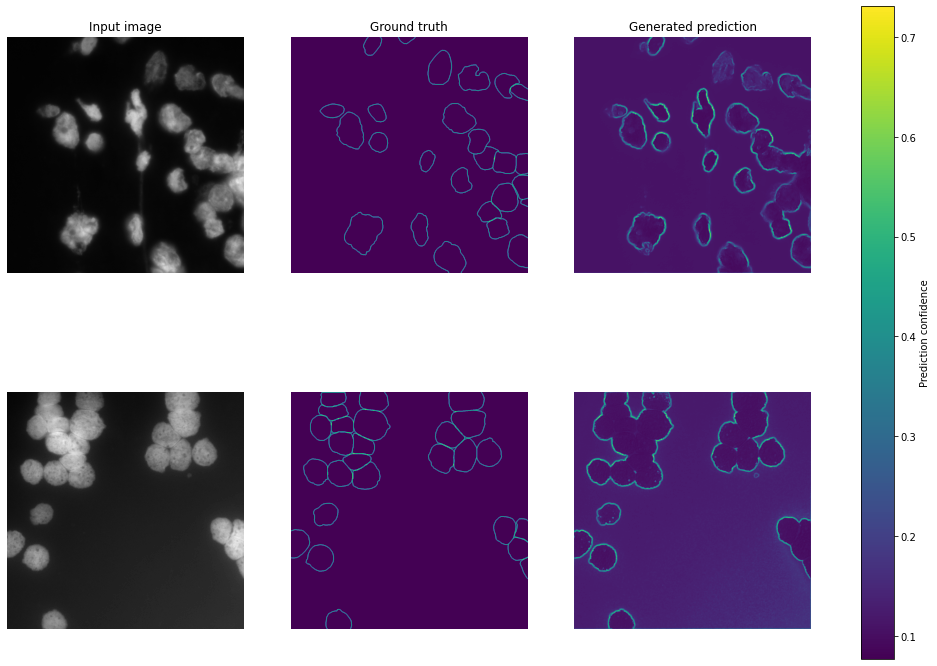

In [90]:
class_index = 1 #@param {type:"slider", min:0, max:2, step:1}
class_index = max(class_index, NUM_CLASSES - 1)
show_results(inputs, labels == class_index, outputs[:, class_index])

In [ ]:
def save_results(input, label, output, cmap="viridis"):
    f = plt.figure(figsize=(6, 6), frameon=False)
    plt.axis("off")
    plt.imshow(input.squeeze())
    plt.savefig("input.png")
    f = plt.figure(figsize=(6, 6), frameon=False)
    plt.axis("off")
    plt.imshow(label.squeeze(), cmap=cmap, interpolation="nearest")
    plt.savefig("label.png")
    f = plt.figure(figsize=(6, 6), frameon=False)
    plt.axis("off")
    plt.imshow(output.squeeze(), cmap=cmap, interpolation="nearest")
    plt.savefig("output.png")

In [97]:
def label_with_watershed(output_predictions, min_distance=50):
  """
    Inputs
      image_three_class: Image to be labelled
      image_two_class: Image to be labelled
      min_distance: Minimum distance that cell-centers should be apart of eachother in
                    pixels
    Outputs:
      Labelled image with every cell having a different value (v > 0) and a border
      between every cell (1-pixel wide)
  """
  # Euclidean distance matrix of the image
  distance = ndi.distance_transform_edt(output_predictions)
  # List of (x,y) pairs representing the coordinates of the peaks
  coords_of_peaks = peak_local_max(distance, min_distance=min_distance, footprint=np.ones((64,64)), labels=output_predictions)
  # Black image with white pixels representing the peaks (cell-centers)
  mask = np.zeros(distance.shape, dtype=bool)
  mask[tuple(coords_of_peaks.T)] = True
  # Mask transformed to having a different value per peak (cell-center)
  markers, _ = ndi.label(mask)

  # Return the watershed labels, use -distance because watershed works on minima.
  return watershed(-distance, markers, mask=output_predictions, watershed_line=True)

# Stardist

In [137]:
!gdown "https://drive.google.com/uc?id=1Xp5lSCOBHc_JX1nnupX8vhzI8CgfXZiu" -O stardist-pretrained.zip
!unzip stardist-pretrained.zip -dstardist

Downloading...
From: https://drive.google.com/uc?id=1Xp5lSCOBHc_JX1nnupX8vhzI8CgfXZiu
To: /content/ml-segmentation-project/stardist-pretrained.zip
5.36MB [00:00, 47.3MB/s]
Archive:  stardist-pretrained.zip
  inflating: stardist/thresholds.json  
  inflating: stardist/config.json    
  inflating: stardist/weights_best.h5  


In [140]:
stardist_model = StarDist2D(None, name='stardist')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.458502, nms_thresh=0.4.


In [148]:
def show_segmentation_results(input, connected, watershed, stardist, cmap):
    fig = plt.figure(figsize=(16, 16))
    axs = fig.subplots(2, 2).flat
    
    column_labels = ["Input image", "Connected Components", "Watershed", "Stardist"]

    for ax, label in zip(axs, column_labels):
        ax.axis("off")
        ax.set_title(label)
        
    axs[0].imshow(input.squeeze(), cmap="gray")
    axs[1].imshow(connected, interpolation="nearest", cmap=cmap)
    axs[2].imshow(watershed, interpolation="nearest", cmap=cmap)
    axs[3].imshow(stardist, interpolation="nearest", cmap=cmap)
    fig.show()

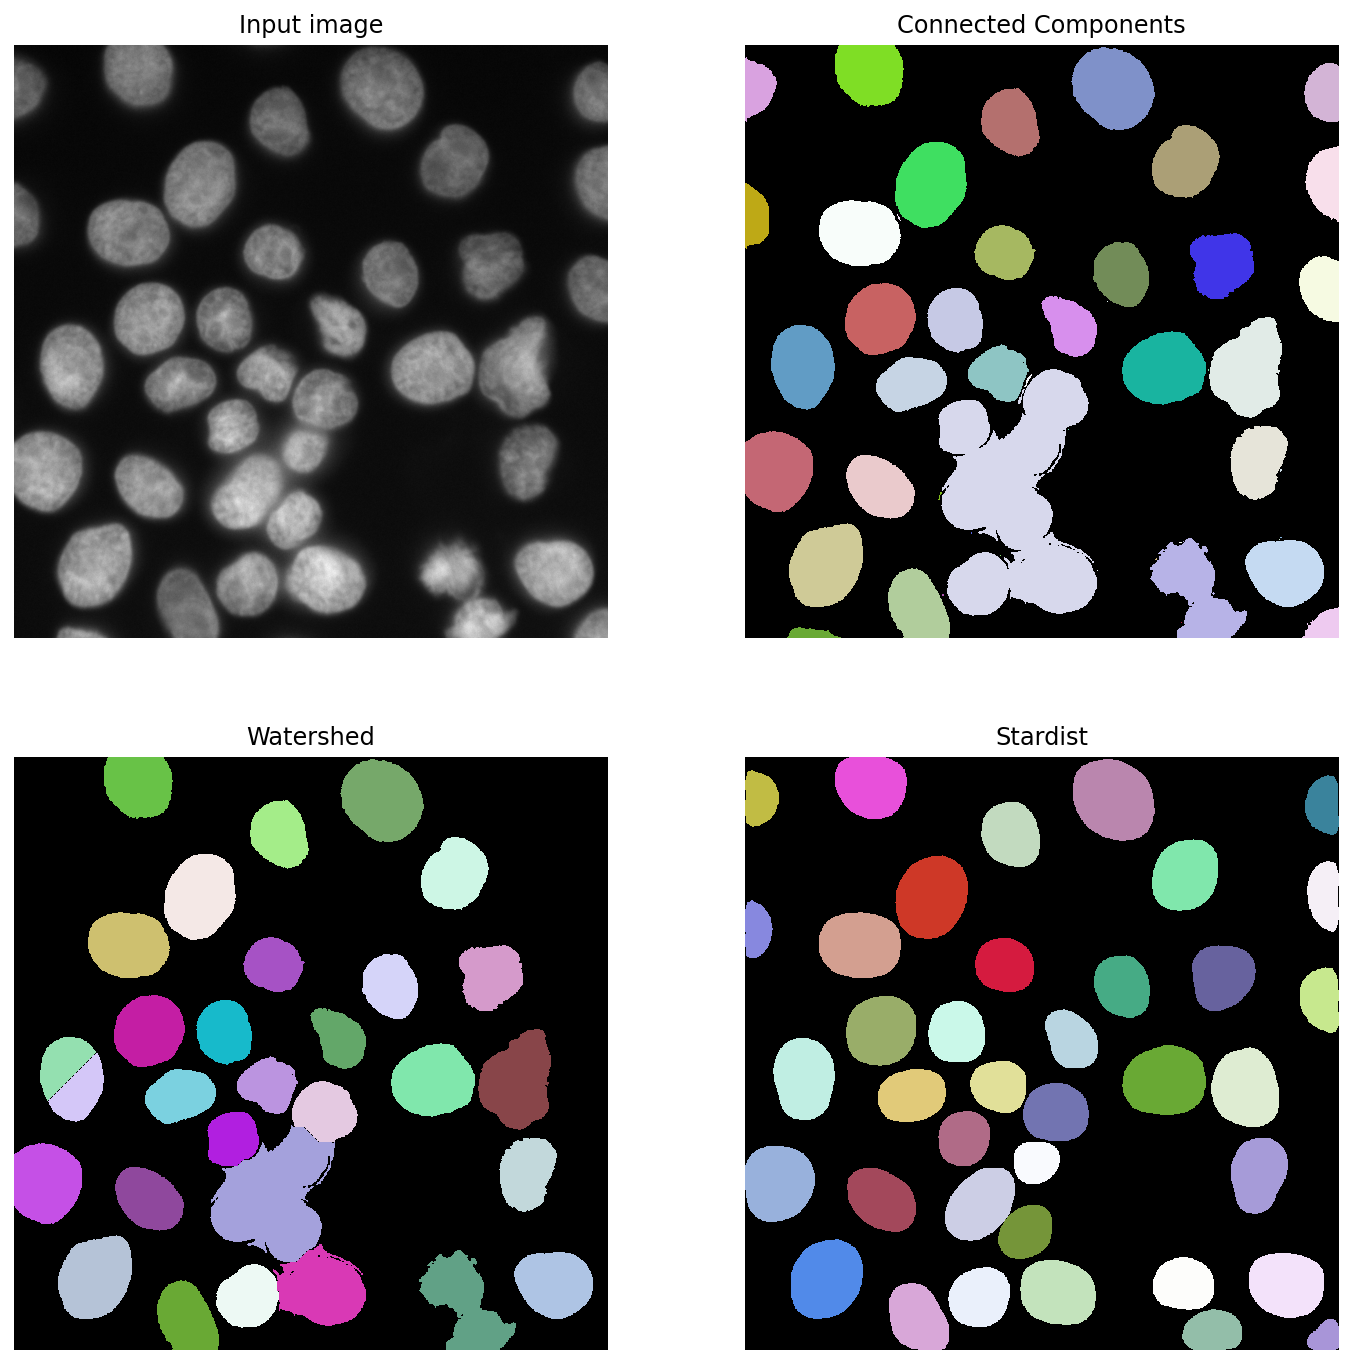

In [150]:
from skimage import measure
from skimage.segmentation import watershed

torch.cuda.empty_cache()

output_classes = outputs.argmax(dim=1).numpy()[0]
watershed_output = label_with_watershed(output_classes == 1)
connected_output = measure.label(output_classes == 1)
stardist_output, _ = stardist_model.predict_instances(inputs[0].numpy().squeeze())

show_segmentation_results(
    inputs[0],
    connected_output,
    watershed_output,
    stardist_output,
    cmap=random_label_cmap()
)

# Metrics graph

In [125]:
label_list = []
water_list = []
connec_list = []
star_list = []


for inputs, labels in val_loader:
  outputs_two_class = model_two_class.predict(inputs.to(device))
  outputs_three_class = model_three_class.predict(inputs.to(device)).argmax(dim=1)

  for i in range(BATCH_SIZE):

    label_list.append(labels[i].numpy().squeeze())
    im_2 = outputs_two_class[i]
    im_3 = outputs_three_class[i]
    connec_list.append(measure.label(im_2))
    UNet_list.append(label_with_watershed(im_3, im_2))
    pred_star, details = model.predict_instances(inputs[i].numpy().squeeze())
    star_list.append(pred_star)

NameError: ignored

In [ ]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(connec_list, star_list, thresh=t, show_progress=False) for t in tqdm(taus)]

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

plt.savefig("/content/drive/MyDrive/metrics_connec.png")